In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/2022_NLP/Machine_Translation/deu-eng.zip

Archive:  /content/drive/MyDrive/2022_NLP/Machine_Translation/deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [ ]:
%cd /content/drive/MyDrive/2022_NLP/Machine_Translation

/content/drive/MyDrive/2022_NLP/Machine_Translation


#  Preparing the Text Data

Problems: 

 There is punctuation.

 The text contains uppercase and lowercase.

 There are special characters in the German.

 There are duplicate phrases in English with different translations in German.

 The file is ordered by sentence length with very long sentences toward the end of the file.

Solutions: normalize each character with their ascii codes

See the function **clean_pairs**

In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [re_punc.sub('', w) for w in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = '/content/deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[eat up] => [iss auf]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[i pa

We will simplify the problem by reducing the dataset to the first 10,000
examples in the file; these will be the shortest phrases in the dataset. Further, we will then
stake the first 9,000 of those as examples for training and the remaining 1,000 examples to test
the fit model.


In [ ]:
from pickle import load
from pickle import dump
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


#  Train Neural Translation Model

In [ ]:
from pickle import load
from numpy import array
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y



# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 2198
English Max Length: 5
German Vocabulary Size: 3537
German Max Length: 9


We are now ready to define the model. We will use an encoder-decoder LSTM model on
this problem. In this architecture, the input sequence is encoded by a front-end model called
the encoder then decoded word by word by a backend model called the decoder. The function
define model() below defines the model and takes a number of arguments used to configure
the model, such as the size of the input and output vocabularies, the maximum length of input
and output phrases, and the number of memory units used to configure the model.

In [ ]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	# compile model
	model.compile(optimizer='adam', loss='categorical_crossentropy')
	# summarize defined model
	model.summary()
	#plot_model(model, to_file='model.png', show_shapes=True)
	return model

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 256)            905472    
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 2198)          564886    
 ibuted)                                                         
                                                                 
Total params: 2,520,982
Trainable params: 2,520,982
Non-

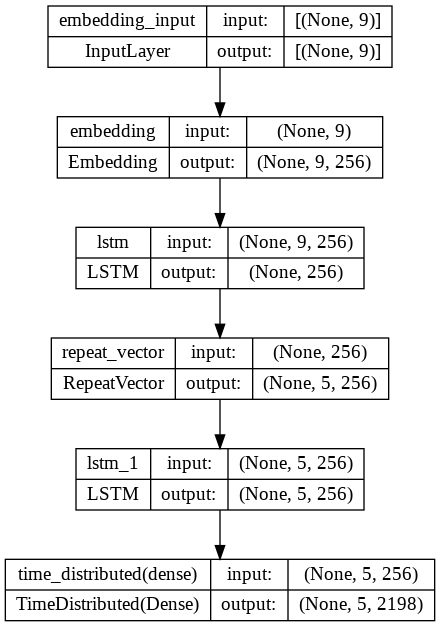

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# fit model
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30

Epoch 1: val_loss improved from inf to 3.43004, saving model to model.h5
141/141 - 32s - loss: 4.1702 - val_loss: 3.4300 - 32s/epoch - 225ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.43004 to 3.29374, saving model to model.h5
141/141 - 24s - loss: 3.2635 - val_loss: 3.2937 - 24s/epoch - 172ms/step
Epoch 3/30

Epoch 3: val_loss improved from 3.29374 to 3.22046, saving model to model.h5
141/141 - 26s - loss: 3.1381 - val_loss: 3.2205 - 26s/epoch - 182ms/step
Epoch 4/30

Epoch 4: val_loss improved from 3.22046 to 3.09623, saving model to model.h5
141/141 - 24s - loss: 3.0210 - val_loss: 3.0962 - 24s/epoch - 168ms/step
Epoch 5/30

Epoch 5: val_loss improved from 3.09623 to 2.96830, saving model to model.h5
141/141 - 24s - loss: 2.8514 - val_loss: 2.9683 - 24s/epoch - 168ms/step
Epoch 6/30

Epoch 6: val_loss improved from 2.96830 to 2.81788, saving model to model.h5
141/141 - 24s - loss: 2.6818 - val_loss: 2.8179 - 24s/epoch - 168ms/step
Epoch 7/30

Epoch 7: val_loss im

#  Evaluate Neural Translation Model

Evaluation involves two steps: first generating a translated output sequence, and then
repeating this process for many input examples and summarizing the skill of the model across
multiple cases. Starting with inference, the model can predict the entire output sequence in a
one-shot manner.

In [ ]:
from numpy import argmax
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src, test = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load model
savepath = "/content/drive/MyDrive/2022_NLP/Machine_Translation/"

model = load_model(savepath + 'model.h5')
# test on some training sequences|
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

train
src=[gebt mir die halfte], target=[give me half], predicted=[give me half]
src=[gib mir das], target=[give it to me], predicted=[give me to me]
src=[es ist auf seite], target=[its on page], predicted=[its came page]
src=[versuchen sies doch einfach], target=[just try it], predicted=[just try it]
src=[nimm meine], target=[take mine], predicted=[take mine]
src=[er will gehen], target=[he wants to go], predicted=[he wants to go]
src=[du solltest hingehen], target=[you should go], predicted=[you should go]
src=[sind wir unter uns], target=[are we alone], predicted=[are we alone]
src=[mach es nicht kaputt], target=[dont break it], predicted=[dont give it]
src=[fahre hier heran], target=[pull over here], predicted=[pull over here]
BLEU-1: 0.878203
BLEU-2: 0.828630
BLEU-3: 0.733671
BLEU-4: 0.416385


The training result looks pretty good seeing the BLEU scores.

Let's experiment with the test data.

In [ ]:
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

test
src=[mach hin], target=[hurry up], predicted=[hop up]
src=[bin ich fruh dran], target=[am i early], predicted=[am i in here]
src=[tom geht zu fu], target=[tom will walk], predicted=[tom walks]
src=[lauf nicht], target=[dont run], predicted=[dont cry]
src=[kannst du es machen], target=[can you do it], predicted=[can you do it]
src=[das ist mir zu hoch], target=[its beyond me], predicted=[nobody one]
src=[zahl bis zehn], target=[count to ten], predicted=[wait a a]
src=[gehen sie weiter], target=[keep walking], predicted=[keep walking]
src=[seid kreativ], target=[be creative], predicted=[be creative]
src=[du bist launisch], target=[youre moody], predicted=[youre witty]
BLEU-1: 0.538981
BLEU-2: 0.408693
BLEU-3: 0.326538
BLEU-4: 0.152299


Still quite satisfying.

Below shows an example not in the training data

In [ ]:
def translate(source):
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  line = normalize('NFD', source).encode('ascii', 'ignore')
  line = line.decode('UTF-8')
  # tokenize on white space
  line = line.split()
  # convert to lowercase
  line = [word.lower() for word in line]
  # remove punctuation from each token
  line = [re_punc.sub('', w) for w in line]
  # remove non-printable chars form each token
  line = [re_print.sub('', w) for w in line]
  # remove tokens with numbers in them
  line = [word for word in line if word.isalpha()]
  source = encode_sequences(ger_tokenizer, ger_length, [line])
  translation = predict_sequence(model, eng_tokenizer, source)
  return translation

source = "es war toll"
translation = translate(source)

print(translation)

it was great


Although the project is not comparable to Goolge Translate, this is a good start for Encoder-Decoder modeling of machine translation.